In [1]:
import pandas as pd
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tdc.single_pred import Tox
import tdc
from ersilia import ErsiliaModel

from scripts.data_loader import DataDownloader
from scripts.eda import ExploratoryDataAnalysis

from rdkit import Chem
from rdkit.Chem import Draw

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

%matplotlib inline

### **Getting to Know Our Data**  

In [2]:
downloader = DataDownloader()

In [3]:
dataset_name = "hERG"
data, df, splits = downloader.fetch_dataset(name = dataset_name, method = "scaffold" )

2025-03-25 22:25:26,136 - INFO - Deleting existing dataset file: /home/gentroyal/outreachy-temp/data/hERG/hERG.csv
2025-03-25 22:25:26,138 - INFO - Downloading 'hERG' dataset...
Found local copy...
Loading...
Done!
2025-03-25 22:25:26,165 - INFO - Dataset 'hERG' saved to /home/gentroyal/outreachy-temp/data/hERG/hERG.csv (Shape: (655, 3))
2025-03-25 22:25:26,166 - INFO - Splitting dataset using 'scaffold' method...
100%|███████████████████| 655/655 [00:00<00:00, 1273.90it/s]
2025-03-25 22:25:26,753 - INFO - Train set saved (Shape: (458, 3))
2025-03-25 22:25:26,755 - INFO - Validation set saved (Shape: (65, 3))
2025-03-25 22:25:26,756 - INFO - Test set saved (Shape: (132, 3))


In [4]:
df.head()

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,LY-97241,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.0
3,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
4,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0


In [5]:
splits.keys()

dict_keys(['train', 'validation', 'test'])

In [6]:
train = splits['train'] #Same as valid and test keys
train.head()

,Drug_ID,Drug,Y
0,DELAVIRDINE,CC(C)Nc1cccnc1N1CCN(C(=O)C2=CC3=C[C@H](NS(C)(=...,0.0
1,SOPHOCARPINE,O=C1C=CC[C@@H]2[C@H]3CCCN4CCC[C@H](CN12)[C@H]34,0.0
2,RALOXIFENE,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0.0
3,N-DEMETHYLOLANZAPINE,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCNCC1,1.0
4,SUNITINIB,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,1.0


In [7]:
df.Y.value_counts()

Y
1.0    451
0.0    204
Name: count, dtype: int64

#### Some Useful Methods  

Some methods gotten from running `help(data)`, the`data` documentation that may be useful later:  
- **`get_label_meaning()`** – get the biomedical meaning of label.
- **`print_stats()`** to print the statistics of the dataset
- **`label_distribution()`** - visualize distribution of labels

This will be updated as needed

In [8]:
data.print_stats() #Exploring print_stats()

--- Dataset Statistics ---
648 unique drugs.
--------------------------


#### **Brief EDA** 

In [9]:
counts = dict(df.Y.value_counts()).items()

for key, value in counts:
    classification = "blockers" if key == 1.0 else "non-blockers"
    print(f"{value} drugs are classified as {classification}")


451 drugs are classified as blockers
204 drugs are classified as non-blockers


In [10]:
dict(df.Y.value_counts()).items()

dict_items([(1.0, 451), (0.0, 204)])

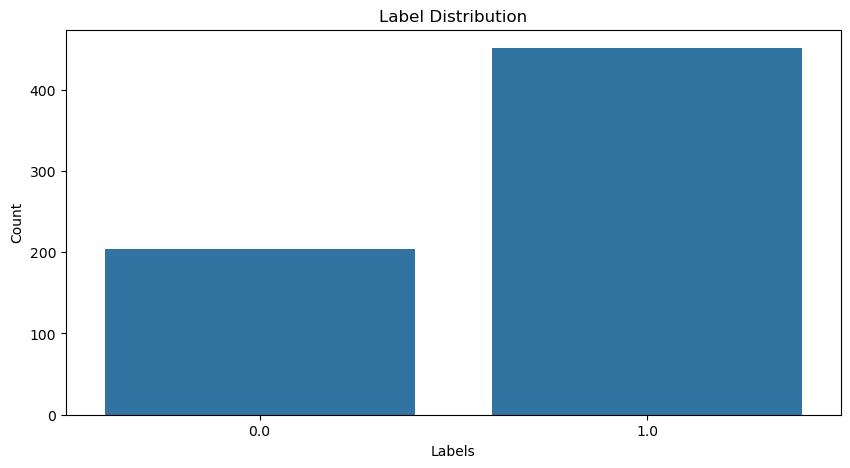

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(x = df.Y.value_counts().index, y = df.Y.value_counts().values)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show();

**Comment:** There are 451 blockers (classed as 1) and and 204 nonblockers (classed as 0). Since there is a huge difference in the number of samples in both classes, it means that there is an imbalance and we need to address this before we can train our machine learning model.

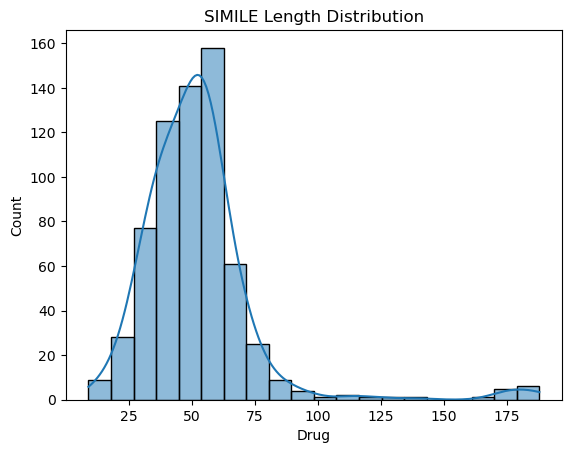

In [12]:
simile_length = df['Drug'].str.len()
sns.histplot(simile_length, bins=20, kde=True)
plt.title("SIMILE Length Distribution")
plt.show()

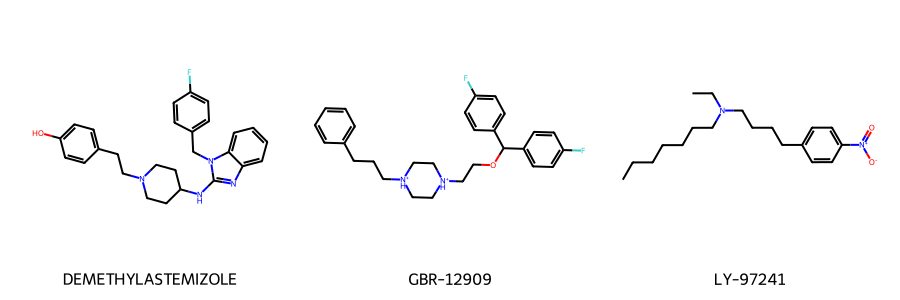

In [13]:
smiles_list = df["Drug"].iloc[:3].tolist()  # First 3 SMILES
drug_names = df["Drug_ID"].iloc[:3].tolist()  # Their  Names

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(300, 300), legends=drug_names)

**Comment:** 

### **Featurizer**  

In [14]:
from pathlib import Path

def featurize(model_id, input_file, dataset_name = f"../data/{dataset_name}"):
    """
    Featurizes the input file using the specified Ersilia model.

    Args:
        model_id (str): The ID of the Ersilia model to use.
        input_file (str): The input file name (without extension).
        dataset_name (str): The dataset directory path. Default is "../data".

    Returns:
        tuple: (time_taken, output_file_path) or (None, None) if an error occurs.
    """
    try:
        t1 = time.time()
        
        # Define file paths
        dataset_path = Path(dataset_name) / input_file
        input_file_path = dataset_path.with_suffix(".csv")
        output_file_path = dataset_path.with_name(f"{input_file}_{model_id}_featurized.csv")

        if not input_file_path.exists():
            print(f"Error: Input file {input_file_path} not found.")
            return None
        
        # Load and serve the Ersilia model
        model = ErsiliaModel(model=model_id)
        model.serve()
        model.run(input=str(input_file_path), output=str(output_file_path))
        featurized_df = pd.read_csv(output_file_path)
        hERG = pd.read_csv("../data/hERG/hERG.csv")
        
        featurized_df = featurized_df.merge(hERG[["Drug", "Y"]], left_on = 'input', right_on = 'Drug', how = "inner")
        featurized_df.drop(columns = ['Drug'], inplace = True)
        featurized_df.to_csv(output_file_path, index = False)

        time_taken = time.time() - t1

        print(f'The time taken to featurize {input_file_path} is {time_taken:.2f}s')
        
        return featurized_df

    except Exception as e:
        print(f"Error during featurization for model {model_id}: {e}")
        return None

In [15]:
files = ['train', 'test', 'validation']

for inputt in files: 
    df = featurize("eos24ci", inputt)

The time taken to featurize ../data/hERG/train.csv is 94.97s
The time taken to featurize ../data/hERG/test.csv is 32.32s
The time taken to featurize ../data/hERG/validation.csv is 30.45s
